In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from wordcloud import WordCloud, STOPWORDS

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
print ('There are {} rows and {} columns in the train dataset'.format(*train.shape))
print ('There are {} rows and {} columns in the test dataset'.format(*test.shape))

There are 159571 rows and 8 columns in the train dataset
There are 153164 rows and 2 columns in the test dataset


In [3]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
#sum of toxic, severe_toxic, obscene, threat, insult, identity_hate
train.iloc[:,2:].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [5]:
train.iloc[:,2:].sum(axis=1).head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    4
7    0
8    0
9    0
dtype: int64

# Distribution of tags/classes

In [6]:
#sum of toxic, severe_toxic, obscene, threat, insult, identity_hate
sums_of_each_class = train.iloc[:,2:].sum()
#sum of classes across a row
sum_of_classes_across_a_row = train.iloc[:,2:].sum(axis=1)
train['not_toxic']=(sum_of_classes_across_a_row==0)

In [7]:
sum_of_non_toxic_comments = train['not_toxic'].sum()
#count number of clean entries
print("Total comments = ",len(train))
percentage_non_toxic_comments = sum_of_non_toxic_comments/len(train) * 100
print("Total non toxic comments = {}".format(sum_of_non_toxic_comments))
print("Percentage of non toxic comments = {}%".format(round(percentage_non_toxic_comments, 2)))
print("Total toxic comments = {}".format(sums_of_each_class.sum()))
print('Percentage of toxic comments = {}%'.format(round(sums_of_each_class.sum()/len(train) * 100, 2)))

Total comments =  159571
Total non toxic comments = 143346
Percentage of non toxic comments = 89.83%
Total toxic comments = 35098
Percentage of toxic comments = 22.0%


__Observation:__ 
1. Around 90% of the dataset does not contain any toxic comments.
2. The remaining 10% of the dataset contains 22% of toxic comments, so there are toxic comments with more than class associated to it.

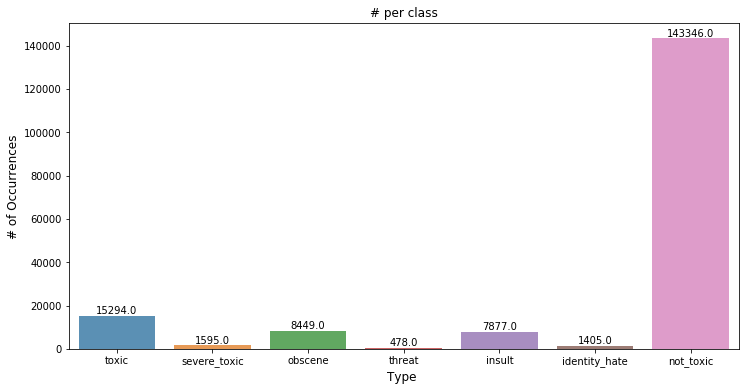

In [8]:
sums_of_each_class = train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(12,6))
ax= sns.barplot(sums_of_each_class.index, sums_of_each_class.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = sums_of_each_class.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# Distribution of multiple tags in a comment

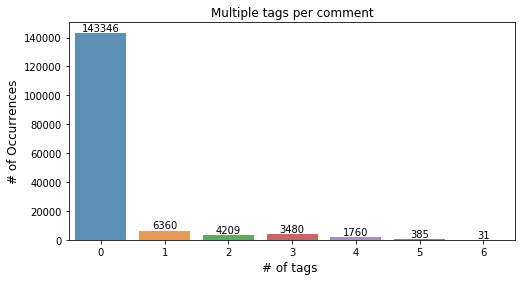

In [13]:
x = sum_of_classes_across_a_row.value_counts()
#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# Which tags go together
To find a pattern between two categorical variables we can use tools such as
- Confusion matrix/Crosstab
- Cramer's V Statistic
    - Cramer's V stat is an extension of the chi-square test where the extent/strength of association is also measured

## Using Confusion Matrix

In [15]:
# get all the tags
tag_df=train.iloc[:,2:-1]

In [14]:
def highlight_min(data, color='yellow'):
    '''
    highlight the minimum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

### Toxic with other tags

In [16]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in tag_df.columns[1:]:
    confusion_matrix = pd.crosstab(tag_df[main_col], tag_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=tag_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

__Observation:__ 
1. A severe toxic comment is always toxic.
2. A threat comment is also always toxic.

### Severe Toxic with other tags

In [21]:
main_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
main_col="severe_toxic"
other_cols = ['toxic', 'obscene', 'threat', 'insult', 'identity_hate']
corr_mats=[]
for other_col in other_cols:
    confusion_matrix = pd.crosstab(tag_df[main_col], tag_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=tag_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

## Using Cramer's V Statistic

In [22]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

### Toxic with other tags

In [28]:
col1="toxic"
other_cols = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# col2="severe_toxic"
for col2 in other_cols:
    confusion_matrix = pd.crosstab(tag_df[col1], tag_df[col2])
    print("Confusion matrix between {} and {}:".format(col1, col2))
    print(confusion_matrix)
    new_corr=cramers_corrected_stat(confusion_matrix)
    print("The correlation between {} and {} using Cramer's stat= {}".format(col1, col2, new_corr))

Confusion matrix between toxic and severe_toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between toxic and severe_toxic using Cramer's stat= 0.30850290540548614
Confusion matrix between toxic and obscene:
obscene       0     1
toxic                
0        143754   523
1          7368  7926
The correlation between toxic and obscene using Cramer's stat= 0.6764644772231891
Confusion matrix between toxic and threat:
threat       0    1
toxic              
0       144248   29
1        14845  449
The correlation between toxic and threat using Cramer's stat= 0.15684415261524137
Confusion matrix between toxic and insult:
insult       0     1
toxic               
0       143744   533
1         7950  7344
The correlation between toxic and insult using Cramer's stat= 0.6474661802275932
Confusion matrix between toxic and identity_hate:
identity_hate       0     1
toxic                      
0              144174 

__Observation:__ Toxic is most correlated with Obscene and least correlated with threat

### Severe Toxic with other tags

In [29]:
col1="severe_toxic"
other_cols = ['toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# col2="severe_toxic"
for col2 in other_cols:
    confusion_matrix = pd.crosstab(tag_df[col1], tag_df[col2])
    print("Confusion matrix between {} and {}:".format(col1, col2))
    print(confusion_matrix)
    new_corr=cramers_corrected_stat(confusion_matrix)
    print("The correlation between {} and {} using Cramer's stat= {}".format(col1, col2, new_corr))

Confusion matrix between severe_toxic and toxic:
toxic              0      1
severe_toxic               
0             144277  13699
1                  0   1595
The correlation between severe_toxic and toxic using Cramer's stat= 0.30850290540548614
Confusion matrix between severe_toxic and obscene:
obscene            0     1
severe_toxic              
0             151044  6932
1                 78  1517
The correlation between severe_toxic and obscene using Cramer's stat= 0.402867277063916
Confusion matrix between severe_toxic and threat:
threat             0    1
severe_toxic             
0             157610  366
1               1483  112
The correlation between severe_toxic and threat using Cramer's stat= 0.12299982239401752
Confusion matrix between severe_toxic and insult:
insult             0     1
severe_toxic              
0             151470  6506
1                224  1371
The correlation between severe_toxic and insult using Cramer's stat= 0.37565458087765363
Confusion matr

# Frequently used words

In [32]:
stopwords = set(STOPWORDS)

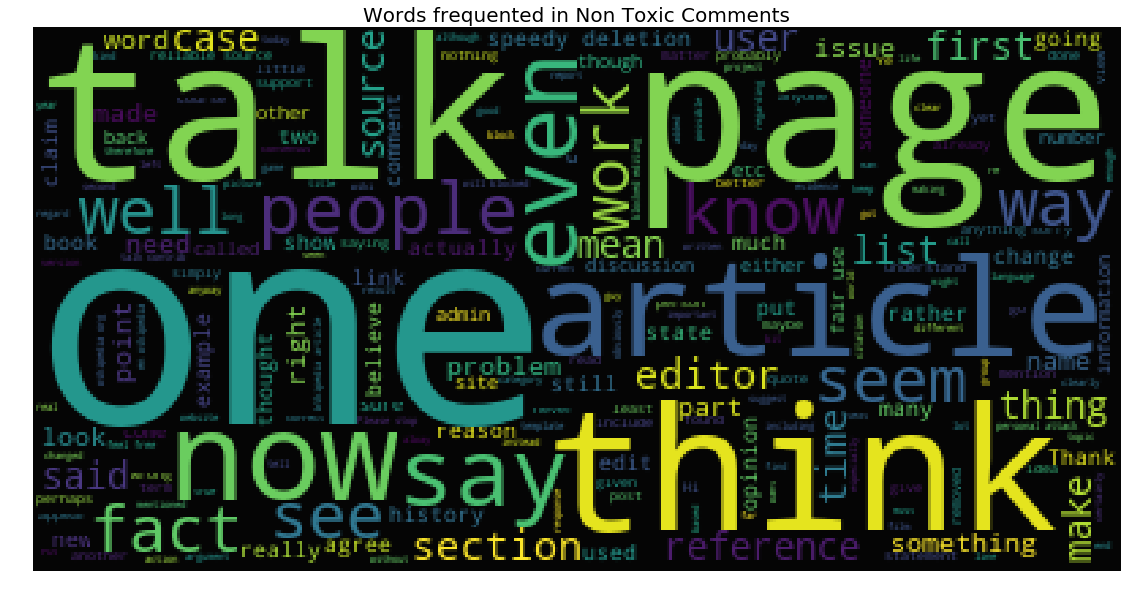

In [38]:
# Ploting word cloud
#wordcloud from non toxic comments
subset=train[train.not_toxic==True]
text=subset.comment_text.values

wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Non Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

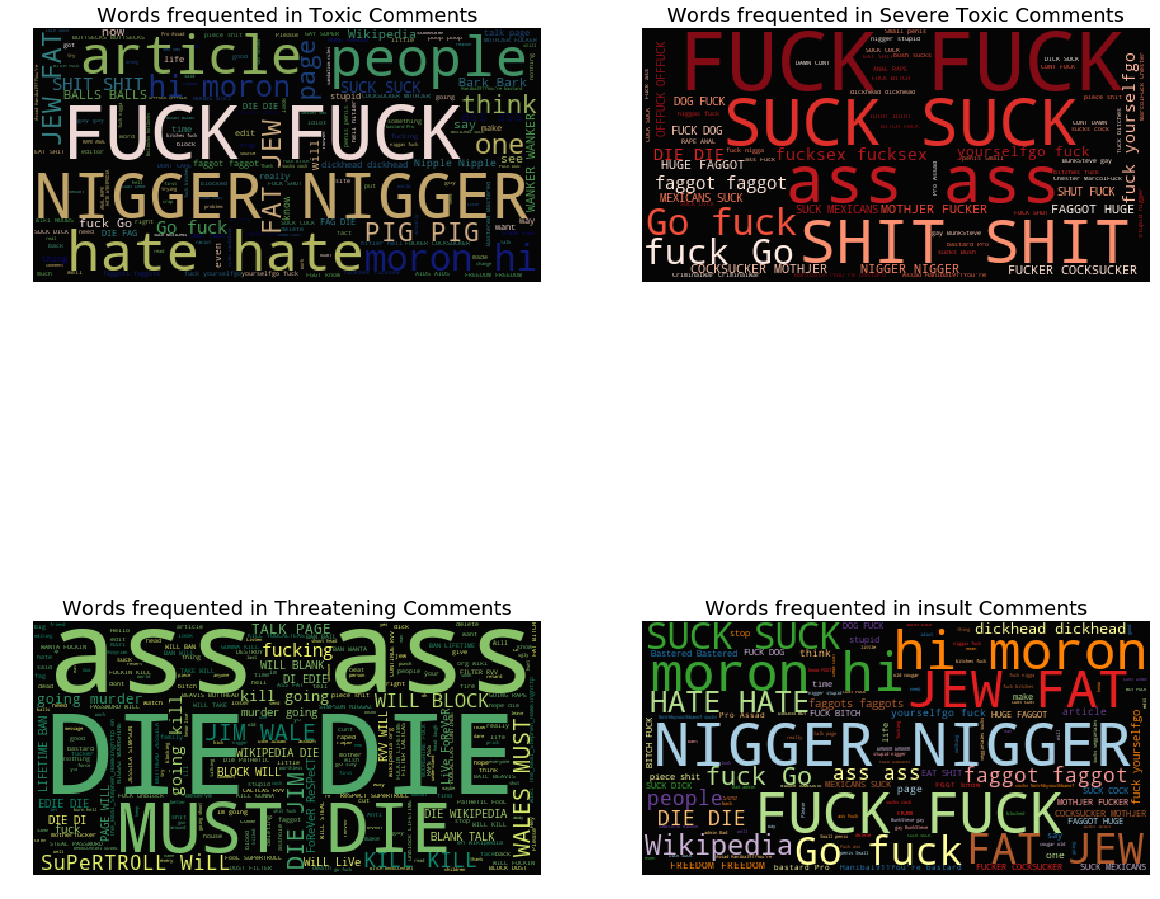

In [41]:
#wordcloud for clean comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()